In [30]:
# If you are a developer, you may want to reload the packages on the fly. 
# Jupyter has a magic for this particular purpose:
%load_ext autoreload
%autoreload 2

# import standard python libraries
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 96
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os, subprocess
from scipy.stats import bootstrap
from textwrap import wrap
from matplotlib import font_manager
font_dirs = ["/home/izhegalova/fonts/"]  # The path to the custom font file.
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
susielu = ["#b84873", "#6dbc5f","#5a3789","#bdab3d","#6d80d8","#bd7635","#bf68b8","#46c19a","#ba4b41","#71883b"]
sns.set_theme(context="paper", style='whitegrid', palette=susielu, font="Arial")

os.chdir('/home/izhegalova/ecoli_microc')

# import libraries for biological data analysis
from coolpuppy import coolpup
from coolpuppy.lib import numutils
from coolpuppy.lib.puputils import divide_pups
from coolpuppy import plotpup
import cooler
import bioframe as bf
import cooltools
from cooltools import expected_cis, expected_trans
from cooltools.lib import plotting

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# %% create bins
resolution = 10
clr = cooler.Cooler('data/wt.combined.MG1655.mapq30.10.mcool::resolutions/' + str(resolution))
clr_44 = cooler.Cooler('data/wt_44C.combined.MG1655.mapq30.10.mcool::resolutions/' + str(resolution))
df_chromsizes = clr.chromsizes
bins = cooler.binnify(df_chromsizes, resolution)
bins.chrom = bins.chrom.astype(str)
fasta_records = bf.load_fasta('data/genome.fasta')
view_df_chromsizes = clr.chromsizes.reset_index()
view_df_chromsizes.columns = ['chrom', 'end']
view_df_chromsizes['start'] = 0
view_df_chromsizes['name'] = 'NC_000913.3'
view_df_chromsizes = view_df_chromsizes[['chrom', 'start', 'end', 'name']]

In [3]:
expected = cooltools.expected_cis(clr, view_df=view_df_chromsizes,
                                nproc=32, 
                                chunksize=100_000,
                                ignore_diags=2) #, median=True
expected_44 = cooltools.expected_cis(clr_44, view_df=view_df_chromsizes,
                                nproc=32, 
                                chunksize=100_000,
                                ignore_diags=2) #, median=True

INFO:root:creating a Pool of 32 workers
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
INFO:root:creating a Pool of 32 workers
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


# Response to Heat

In [3]:
df_go = pd.read_table('data/All-genes-of-E.-coli-K-12-substr.-MG1655-GOterms.txt')
df_go = df_go.loc[:,[ 'Accession-1', 'GO terms (biological process)', 
                     'GO terms (cellular component)', 'GO terms (molecular function)']]
df_go.dropna(subset=['GO terms (biological process)', 
                  'GO terms (cellular component)', 'GO terms (molecular function)'], 
          inplace=True)
df_go.drop_duplicates(inplace=True)
df_go.head()

,Accession-1,GO terms (biological process),GO terms (cellular component),GO terms (molecular function)
138,b4661,GO:0009297 // GO:0055085 // GO:0043711,GO:0016020 // GO:0009279,GO:0015473
173,b4623,GO:0006313 // GO:0015074 // GO:0032196 // GO:0...,GO:0005829,GO:0004803 // GO:0003676 // GO:0003677
177,b4618,GO:0098656 // GO:0006974 // GO:0022611 // GO:0...,GO:0005886 // GO:0016020,GO:0005253
193,b4602,GO:0071456,GO:0005886 // GO:0070069 // GO:0016020,GO:0005515
195,b4599,GO:0010960 // GO:0010350,GO:0005886 // GO:0016020,GO:0005515


In [4]:
df_go = (df_go.set_index(['Accession-1','GO terms (biological process)', 
                  'GO terms (cellular component)'])
   .apply(lambda x: x.str.split(' // ').explode())
   .reset_index())   
df_go = (df_go.set_index(['Accession-1','GO terms (molecular function)', 
                  'GO terms (cellular component)'])
   .apply(lambda x: x.str.split(' // ').explode())
   .reset_index())  
df_go = (df_go.set_index(['Accession-1','GO terms (biological process)', 
                  'GO terms (molecular function)'])
   .apply(lambda x: x.str.split(' // ').explode())
   .reset_index()) 
df_go_melted = pd.melt(df_go, id_vars='Accession-1')
df_go_melted.drop_duplicates(inplace=True)
df_go_melted.columns = ['Accession-1', 'group', 'GO']
df_go_melted.head()

,Accession-1,group,GO
0,b4661,GO terms (biological process),GO:0009297
2,b4661,GO terms (biological process),GO:0055085
4,b4661,GO terms (biological process),GO:0043711
6,b4623,GO terms (biological process),GO:0006313
7,b4623,GO terms (biological process),GO:0015074


In [6]:
TU_df = pd.read_csv('data/Operon_TU_counts.tsv', sep='\t', index_col=0)
TU_df.columns = ['chrom', 'start', 'end', 'TU_name', 'strand', 'GeneID', 'genes', 'ngenes', 
                 'protein_codin', 
                 'sigma', 'nascent_wt',
                 'totat_wt', 'nascent_wt44', 'totat_wt44']

TU_df = TU_df.query('protein_codin == True')
TU_df['chrom'] = 'NC_000913.3'
TU_df['length'] = TU_df.end - TU_df.start
bin_labels_4 = ['short', '25-50%', '50-75%', 'long']
TU_df['length_group'] = pd.qcut(TU_df['length'], 4, labels=False)
TU_df['lengthBool_group'] = np.where(TU_df['length'] > TU_df.length.median(), 'long', 'short')

bin_labels_4 = ['bottom 50%', '50-75%', '75-90%', '>90%']
TU_df['nascentCust_group'] = pd.qcut(TU_df['nascent_wt'], 
                                          q=[0, .5, .75, .9, 1],
                                          labels=bin_labels_4)
TU_df['HeatResponsegroup'] = 'no'
TU_df.head()

,chrom,start,end,TU_name,strand,GeneID,genes,ngenes,protein_codin,sigma,nascent_wt,totat_wt,nascent_wt44,totat_wt44,length,length_group,lengthBool_group,nascentCust_group,HeatResponsegroup
0,NC_000913.3,1004768,1005778,pyrD,+,operon_tu1,pyrD,1,True,sigma70,0,49,0,93,1010,1,short,bottom 50%,no
1,NC_000913.3,1005952,1006494,zapC,+,operon_tu2,zapC,1,True,unknown,3,296,19,783,542,0,short,50-75%,no
2,NC_000913.3,1006491,1007600,ycbX,-,operon_tu3,ycbX,1,True,unknown,0,146,2,122,1109,1,short,bottom 50%,no
3,NC_000913.3,1007844,1011871,rlmL-uup,+,operon_tu4,rlmL;uup,2,True,unknown,1,341,22,901,4027,3,long,bottom 50%,no
4,NC_000913.3,1012001,1015459,pqiABC,+,operon_tu5,pqiA;pqiB;pqiC,3,True,sigma38,8,318,19,818,3458,3,long,75-90%,no


In [7]:
operons_df = pd.read_table('data/operon_counts.tsv')
operons_df['length'] = operons_df.end - operons_df.start


operons_df['chrom'] = 'NC_000913.3'
bin_labels_4 = ['short', '25-50%', '50-75%', 'long']
operons_df['length_group'] = pd.qcut(operons_df['length'], 4, labels=False)
operons_df['lengthBool_group'] = np.where(operons_df['length'] > operons_df.length.median(), 'long', 'short')

bin_labels_4 = ['bottom 50%', '50-75%', '75-90%', '>90%']
operons_df['nascentCust_group'] = pd.qcut(operons_df['nascent_wt'], 
                                          q=[0, .5, .75, .9, 1],
                                          labels=bin_labels_4)
bin_labels_nascent = ['0-33.3%', '33.3%-66.6%', '66.6-100%']
operons_df['nascent_group'] = pd.qcut(operons_df['nascent_wt'], 3, labels=bin_labels_nascent)
operons_df.head()

,chrom,operon_name,strand,GeneID,genes,sigma,nascent_wt,totat_wt,nascent_wt44,totat_wt44,operon_id,start,end,keep,length,length_group,lengthBool_group,nascentCust_group,nascent_group
0,NC_000913.3,pyrD,+,operon_tu1,pyrD,sigma70,0,49,0,93,RDBECOLIOPC00922,1004768,1005778,False,1010,1,short,bottom 50%,0-33.3%
1,NC_000913.3,zapC,+,operon_tu2,zapC,unknown,3,296,19,783,RDBECOLIOPC00296,1005952,1006494,False,542,0,short,50-75%,33.3%-66.6%
2,NC_000913.3,ycbX,-,operon_tu3,ycbX,unknown,0,146,2,122,RDBECOLIOPC00806,1006491,1007600,False,1109,1,short,bottom 50%,0-33.3%
3,NC_000913.3,rlmL-uup,+,operon_tu4,rlmL;uup,unknown,1,341,22,901,RDBECOLIOPC00541,1007844,1011871,True,4027,3,long,bottom 50%,0-33.3%
4,NC_000913.3,pqiABC,+,operon_tu5,pqiA;pqiB;pqiC,sigma38,8,318,19,818,RDBECOLIOPC02217,1012001,1015459,True,3458,3,long,75-90%,66.6-100%


## HeatResponse - GO

In [7]:
df_genes = pd.read_table('data/All-genes-of-E.-coli-K-12-substr.-MG1655---GO.txt')
df = pd.merge(df_go_melted, df_genes, on='Accession-1', suffixes=['_go', '_gene'])
bool_list = df['GO'].str.contains('GO:0009408')
df_heatResponse = df.loc[bool_list,:]
df_heatResponse.head()

,Accession-1,group,GO,Gene Name,Product,GO terms (biological process),GO terms (cellular component),GO terms (molecular function),UniProt,Synonyms
41,b4539,GO terms (biological process),GO:0009408,yoeB,ribosome-dependent mRNA interferase toxin YoeB,negative regulation of DNA-templated transcrip...,toxin-antitoxin complex // cytosol,RNA binding // nuclease activity // endonuclea...,P69348,NaN
671,b4175,GO terms (biological process),GO:0009408,hflC,regulator of FtsH protease,response to heat,plasma membrane protein complex // membrane //...,protein binding,P0ABC3,hflA
672,b4174,GO terms (biological process),GO:0009408,hflK,regulator of FtsH protease,response to heat,plasma membrane protein complex // membrane //...,protein binding,P0ABC7,hslY // hflA
677,b4173,GO terms (biological process),GO:0009408,hflX,ribosome rescue factor HflX,viral latency // peptidyl-serine autophosphory...,cytoplasm // cytosol,metal ion binding // nucleotide binding // ATP...,P25519,hslX // hflA
780,b4143,GO terms (biological process),GO:0009408,groL,chaperonin GroEL,mitochondrial unfolded protein response // pos...,membrane // cytoplasm // GroEL-GroES complex /...,protein-folding chaperone binding // ATP-depen...,P0A6F5,groEL // mopA


In [23]:
heatResponse_list = df_heatResponse['Gene Name'].tolist()
TU_df_splittedGenes = (operons_df.loc[:,['operon_name', 'genes']].set_index(['operon_name'])
       .apply(lambda x: x.str.split(';').explode())
       .reset_index()) 
TU_name_list = TU_df_splittedGenes.operon_name[TU_df_splittedGenes.genes.isin(heatResponse_list)].tolist()
operons_df.loc[operons_df.operon_name.isin(TU_name_list),'HeatResponsegroup'] = 'GO_HR'
operons_df.head()

,chrom,operon_name,strand,GeneID,genes,sigma,nascent_wt,totat_wt,nascent_wt44,totat_wt44,operon_id,start,end,keep,length,length_group,lengthBool_group,nascentCust_group,nascent_group,HeatResponsegroup
0,NC_000913.3,pyrD,+,operon_tu1,pyrD,sigma70,0,49,0,93,RDBECOLIOPC00922,1004768,1005778,False,1010,1,short,bottom 50%,0-33.3%,NaN
1,NC_000913.3,zapC,+,operon_tu2,zapC,unknown,3,296,19,783,RDBECOLIOPC00296,1005952,1006494,False,542,0,short,50-75%,33.3%-66.6%,NaN
2,NC_000913.3,ycbX,-,operon_tu3,ycbX,unknown,0,146,2,122,RDBECOLIOPC00806,1006491,1007600,False,1109,1,short,bottom 50%,0-33.3%,NaN
3,NC_000913.3,rlmL-uup,+,operon_tu4,rlmL;uup,unknown,1,341,22,901,RDBECOLIOPC00541,1007844,1011871,True,4027,3,long,bottom 50%,0-33.3%,NaN
4,NC_000913.3,pqiABC,+,operon_tu5,pqiA;pqiB;pqiC,sigma38,8,318,19,818,RDBECOLIOPC02217,1012001,1015459,True,3458,3,long,75-90%,66.6-100%,NaN


## Sigma32

In [12]:
sigma32_HR_TU_df = operons_df.query('lengthBool_group == "long" and sigma == "sigma32"')
sigma32_HR_TU_df['HeatResponsegroup'] = 'sigma32_HR'
sigma32_HR_TU_df.head()

,chrom,operon_name,strand,GeneID,genes,sigma,nascent_wt,totat_wt,nascent_wt44,totat_wt44,operon_id,start,end,keep,length,length_group,lengthBool_group,nascentCust_group,nascent_group,HeatResponsegroup
91,NC_000913.3,phoPQ,-,operon_tu117,phoP;phoQ,sigma32,13,1033,41,1446,RDBECOLIOPC02441,1188316,1190447,True,2131,2,long,75-90%,66.6-100%,sigma32_HR
108,NC_000913.3,tpke11,+,operon_tu140,dnaK;tpke11;dnaJ,sigma32,15,1875,7798,198154,RDBECOLIOPC02434,12163,15298,True,3135,3,long,75-90%,66.6-100%,sigma32_HR
183,NC_000913.3,ycjXF-tyrR,+,operon_tu243,ycjX;ycjF;tyrR,sigma32,12,587,132,5030,RDBECOLIOPC03235,1384117,1388261,True,4144,3,long,75-90%,66.6-100%,sigma32_HR
187,NC_000913.3,ycjY-ymjDC-mpaA,-,operon_tu247,ycjY;ymjD;ymjC;mpaA,sigma32,0,403,4,503,RDBECOLIOPC03456,1389870,1391853,True,1983,2,long,bottom 50%,0-33.3%,sigma32_HR
442,NC_000913.3,sdaA,+,operon_tu593,sdaA,sigma32,23,931,55,2225,RDBECOLIOPC02116,1896932,1898296,False,1364,2,long,>90%,66.6-100%,sigma32_HR


## FC TU

<Axes: ylabel='FC'>

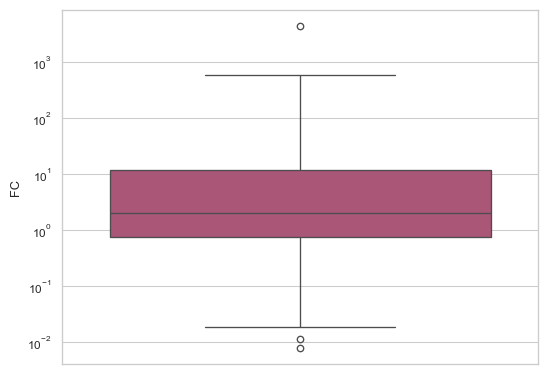

In [13]:
operons_df['nascent_wt_CPM'] = operons_df.nascent_wt / 4258792 * 1000000
operons_df['nascent_wt44_CPM'] = operons_df.nascent_wt44 / 6936811 * 1000000
operons_df['FC'] = operons_df.nascent_wt44_CPM / (operons_df.nascent_wt_CPM + 0.01)
sns.boxplot(data=operons_df,y='FC',log_scale=True)

In [13]:
wt44_thr = np.quantile(TU_df.nascent_wt44, 0.95)
FC_HR_TU_df = TU_df.query('FC > 4 and lengthBool_group == "long" and nascent_wt44 > @wt44_thr')
FC_HR_TU_df['HeatResponsegroup'] = 'FC_HR'

## Hi-C heatResponse

In [7]:
clr.info['sum']

662252537

In [6]:
clr_44.info['sum']

664713703

In [95]:
HR_TU_df = pd.concat([TU_df.query('HeatResponsegroup != "no"'), FC_HR_TU_df, sigma32_HR_TU_df])
HR_TU_df.HeatResponsegroup.value_counts()

NameError: name 'FC_HR_TU_df' is not defined

In [134]:
HR_TU_df.length.median()

2015.0

In [15]:
flank = 2000
pup_median = coolpup.pileup(clr_44, HR_TU_df.query('lengthBool_group == "long"'), 
                     groupby=['HeatResponsegroup1'],
                     features_format='bed', 
                     view_df=view_df_chromsizes, local=True,
                     rescale=True, rescale_size=int(1+flank * 2// resolution),  
                     rescale_flank=1,
                     #expected_df=expected,
                     flip_negative_strand=True,
                     flank=flank, min_diag=10, nproc=32,
                    mean_bool=False)
# sns.set_theme(font_scale=2, style="ticks")
# plotpup.plot(pup,
# #              rows='lengthBool_group1', row_order=['long'],
#              cols='HeatResponsegroup1', 
#              # col_order=['bottom 50%', '50-75%', '75-90%', '>90%'],
#              score=False, cmap='fall', scale='log', sym=False,
#              vmin=0.000005, vmax=0.0005, #suitable fo rescale_flank=5, flank=10k
#              #vmin=0.000015, vmax=0.001,
#              height=5)

# plt.savefig('results/wt44_av_TU.3WaysHR.flank1.FC4.10bp.pdf', dpi=100, bbox_inches='tight')
# plt.show()

/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/coolpuppy/coolpup.py:944: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  chroffset = self.clr.offset(region[0])
INFO:coolpuppy:Rescaling with rescale_flank = 1 to 401x401 pixels


{'NC_000913.3'}


INFO:coolpuppy:('NC_000913.3', 'NC_000913.3'): 92
INFO:coolpuppy:Total number of piled up windows: 92
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/coolpuppy/coolpup.py:2186: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pups["expected"] = pups["expected"].fillna(False)


In [ ]:
flank = 2000
pup_wt = coolpup.pileup(clr, HR_TU_df.query('lengthBool_group == "long"'), 
                     groupby=['HeatResponsegroup1'],
                     features_format='bed', 
                     view_df=view_df_chromsizes, local=True,
                     rescale=True, rescale_size=int(1+flank * 2// resolution),  
                     rescale_flank=1,
                     #expected_df=expected,
                     flip_negative_strand=True,
                     flank=flank, min_diag=10, nproc=32,
                    mean_bool=False)
# sns.set_theme(font_scale=2, style="ticks")
# plotpup.plot(pup_wt,
# #              rows='lengthBool_group1', row_order=['long'],
#              cols='HeatResponsegroup1', 
#              # col_order=['bottom 50%', '50-75%', '75-90%', '>90%'],
#              score=False, cmap='fall', scale='log', sym=False,
#              vmin=0.000005, vmax=0.0005, #suitable fo rescale_flank=5, flank=10k
#              #vmin=0.000015, vmax=0.001,
#              height=5)

# plt.savefig('results/wt_av_TU.3WaysHR.flank1.FC4.10bp.pdf', dpi=100, bbox_inches='tight')
# plt.show()

/scratch/ipykernel_3524618/874987147.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[letter].set(xticks=[], yticklabels=ticks_borders,
/scratch/ipykernel_3524618/874987147.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[letter].set(xticks=ticks_pixels_borders, xticklabels=ticks_borders, yticklabels=ticks_borders,


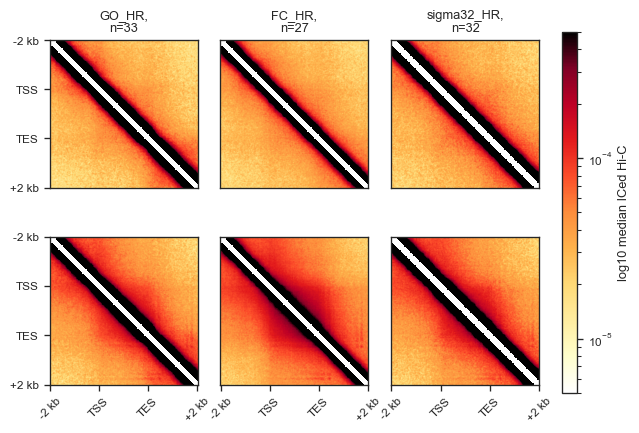

<Figure size 614.4x460.8 with 0 Axes>

In [21]:
import matplotlib.cm
import cooltools.lib.plotting
from matplotlib.ticker import EngFormatter

# helper functions for plotting
bp_formatter = EngFormatter('b')
def format_ticks(ax, x=True, y=True, rotate=True):
    """format ticks with genomic coordinates as human readable"""
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
        ax.yaxis.tick_left()
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)
        
sns.set_theme(context="paper", style='white', palette=susielu, font="Arial")
cm = 1/2.54  # centimeters in inches
fig, axs = plt.subplot_mosaic(
    """
    ABCG
    DEFG
    """
    ,figsize=(18*cm, 4*3.1*cm),gridspec_kw={'width_ratios':[1,1,1, 0.1]})

# Load colormap with large number of distinguishable intermediary tones,
# The "fall" colormap in cooltools is exactly for this purpose.
# After this step, you can use "fall" as cmap parameter in matplotlib:

i = 0
norm = mpl.colors.LogNorm(vmin=0.000005, vmax=0.0005) 
ticks_pixels = np.linspace(0, flank*2//resolution,5)
ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*resolution//1000).astype(int)
ticks_pixels_borders = [0, 133, 266, 400]
ticks_borders = ['-2 kb', 'TSS', 'TES', '+2 kb']

for letter in ['A','B','C']:
    im = axs[letter].imshow(
        pup_wt.loc[i, 'data'],
        norm=norm,
        cmap='fall',
        interpolation='gaussian')
    format_ticks(axs[letter], rotate=True)
    if letter == "A":
        axs[letter].set(xticks=[], yticklabels=ticks_borders, 
                         yticks=ticks_pixels_borders, title="%s,\nn=%s" %(pup_median.HeatResponsegroup1[i], pup_median.n[i]),
                         #ylabel="\n".join(wrap('relative position from, kbp', 25))
                       )
    else:
        axs[letter].set(xticks=[], title="%s,\nn=%s" %(pup_median.HeatResponsegroup1[i], pup_median.n[i]),
                        #xticklabels=ticks_kbp,
                        yticks=[])
    i += 1
    
i = 0
for letter in ['D','E','F']:
    im = axs[letter].imshow(
        pup_median.loc[i, 'data'],
        norm=norm,
        #vmin=0.000005, vmax=0.0005,
        cmap='fall',
        interpolation='gaussian')
    format_ticks(axs[letter], rotate=True)
    if letter == "D":
        axs[letter].set(xticks=ticks_pixels_borders, xticklabels=ticks_borders, yticklabels=ticks_borders, 
                         yticks=ticks_pixels_borders, #xlabel="\n".join(wrap('relative position, kbp', 25)), 
                         #ylabel="\n".join(wrap('relative position from, kbp', 25))
                       )
    else:
        axs[letter].set(xticks=ticks_pixels_borders, xticklabels=ticks_borders,
                         yticks=[], #xlabel="\n".join(wrap('relative position, kbp', 25))
                       )
    i += 1 

cax = axs['G']
fig.colorbar(matplotlib.cm.ScalarMappable(norm, 'fall'), cax=cax, label = 'log10 median ICed Hi-C')

plt.savefig('results/HP_TU_hic.median.pdf', dpi=100, bbox_inches='tight')
plt.show()
plt.clf()

## sigma 2x2

In [13]:
flank = 2000
pup_wt = coolpup.pileup(clr, sigma32_HR_TU_df.query('lengthBool_group == "long"'), 
                     groupby=['HeatResponsegroup1'],
                     features_format='bed', 
                     view_df=view_df_chromsizes, local=True,
                     rescale=True, rescale_size=int(1+flank * 2// resolution),  
                     rescale_flank=1,
                     # expected_df=expected,
                     flip_negative_strand=True,
                     flank=flank, min_diag=10, nproc=32,
                     mean_bool=False) 

{'NC_000913.3'}


/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/coolpuppy/coolpup.py:944: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  chroffset = self.clr.offset(region[0])
INFO:coolpuppy:Rescaling with rescale_flank = 1 to 401x401 pixels
INFO:coolpuppy:('NC_000913.3', 'NC_000913.3'): 25
INFO:coolpuppy:Total number of piled up windows: 25
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/coolpuppy/coolpup.py:2186: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pups["expected"] = pups["expected"].fillna(False)


In [14]:
flank = 2000
pup_wt44 = coolpup.pileup(clr_44, sigma32_HR_TU_df.query('lengthBool_group == "long"'), 
                     groupby=['HeatResponsegroup1'],
                     features_format='bed', 
                     view_df=view_df_chromsizes, local=True,
                     rescale=True, rescale_size=int(1+flank * 2// resolution),  
                     rescale_flank=1,
                     # expected_df=expected,
                     flip_negative_strand=True,
                     flank=flank, min_diag=10, nproc=32,
                     mean_bool=False)

/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/coolpuppy/coolpup.py:944: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  chroffset = self.clr.offset(region[0])
INFO:coolpuppy:Rescaling with rescale_flank = 1 to 401x401 pixels


{'NC_000913.3'}


INFO:coolpuppy:('NC_000913.3', 'NC_000913.3'): 25
INFO:coolpuppy:Total number of piled up windows: 25
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/coolpuppy/coolpup.py:2186: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pups["expected"] = pups["expected"].fillna(False)


## ooe

In [15]:
flank = 2000
pup_44_ooe = coolpup.pileup(clr_44, sigma32_HR_TU_df.query('lengthBool_group == "long"'), 
                     groupby=['HeatResponsegroup1'],
                     features_format='bed', 
                     view_df=view_df_chromsizes, local=True,
                     rescale=True, rescale_size=int(1+flank * 2// resolution),  
                     rescale_flank=1,
                     expected_df=expected_44,
                     flip_negative_strand=True,
                     flank=flank, min_diag=10, nproc=32,
                    mean_bool=False)

{'NC_000913.3'}


/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/cooltools/api/snipping.py:762: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region1_coords[0]
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/cooltools/api/snipping.py:765: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region2_coords[0]
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/coolpuppy/coolpup.py:944: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a va

In [16]:
flank = 2000
pup_wt_ooe = coolpup.pileup(clr, sigma32_HR_TU_df.query('lengthBool_group == "long"'), 
                     groupby=['HeatResponsegroup1'],
                     features_format='bed', 
                     view_df=view_df_chromsizes, local=True,
                     rescale=True, rescale_size=int(1+flank * 2// resolution),  
                     rescale_flank=1,
                     expected_df=expected,
                     flip_negative_strand=True,
                     flank=flank, min_diag=10, nproc=32,
                     mean_bool=False)

{'NC_000913.3'}


/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/cooltools/api/snipping.py:762: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region1_coords[0]
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/cooltools/api/snipping.py:765: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region2_coords[0]
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/coolpuppy/coolpup.py:944: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a va

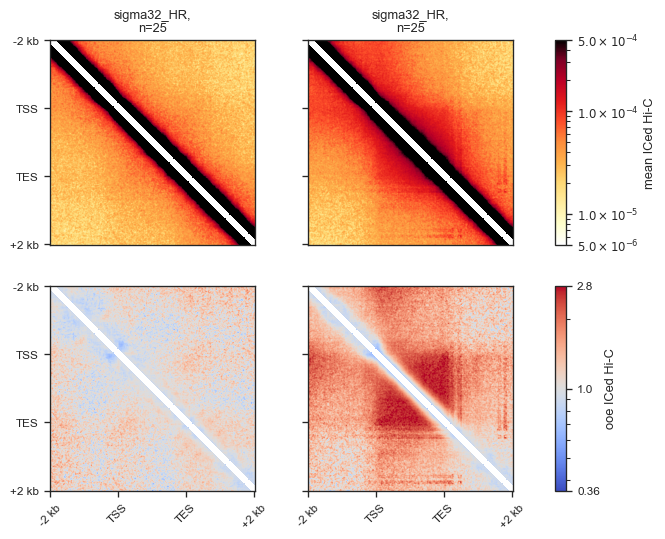

<Figure size 614.4x460.8 with 0 Axes>

In [22]:
import matplotlib.cm
import cooltools.lib.plotting
from matplotlib.ticker import EngFormatter
from matplotlib.ticker import FuncFormatter

# helper functions for plotting
bp_formatter = EngFormatter('b')
def format_ticks(ax, x=True, y=True, rotate=True):
    """format ticks with genomic coordinates as human readable"""
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
        ax.yaxis.tick_left()
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

# fmt = lambda x, pos: '{:.1g}'.format(x)#.split('e')
# fmt = '.3g'
def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)
    
sns.set_theme(context="paper", style='white', palette=susielu, font="Arial")
cm = 1/2.54  # centimeters in inches
fig, axs = plt.subplot_mosaic(
    """
    ABJ
    CDI
    """
    ,figsize=(18*cm, 5*3.1*cm),gridspec_kw={'width_ratios':[1, 1, 0.05]})

# Load colormap with large number of distinguishable intermediary tones,
# The "fall" colormap in cooltools is exactly for this purpose.
# After this step, you can use "fall" as cmap parameter in matplotlib:

i = 0
norm = mpl.colors.LogNorm(vmin=0.36, vmax=2.8) 
ticks_pixels = np.linspace(0, flank*2//resolution,5)
ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*resolution//1000).astype(int)
ticks_pixels_borders = [0, 133, 266, 400]
ticks_borders = ['-2 kb', 'TSS', 'TES', '+2 kb']

for letter in ['A', 'B', 'C', 'D']:
    if letter in ['A','B']:
        norm = mpl.colors.LogNorm(vmin=0.000005, vmax=0.0005) 
    if letter in ['C', 'D']:
        norm = mpl.colors.LogNorm(vmin=0.36, vmax=2.8) 
    if letter == "A":
        im = axs[letter].imshow(
            pup_wt.loc[i, 'data'],
            norm=norm,
            cmap='fall',
            interpolation='gaussian')
        format_ticks(axs[letter], rotate=True)
        axs[letter].set(xticks=[], yticks=ticks_pixels_borders,
                        yticklabels=ticks_borders, 
                        title="%s,\nn=%s" %(pup_wt.HeatResponsegroup1[i], 
                                                                          pup_wt_ooe.n[i]),
                         #ylabel="\n".join(wrap('relative position from, kbp', 25))
                       )
    if letter == "B":
        im = axs[letter].imshow(
            pup_wt44.loc[i, 'data'],
            norm=norm,
            cmap='fall',
            interpolation='gaussian')
        format_ticks(axs[letter], rotate=True)
        axs[letter].set(xticks=[], yticks=ticks_pixels_borders,
                        yticklabels=[], 
                        title="%s,\nn=%s" %(pup_wt44.HeatResponsegroup1[i], 
                                                                          pup_wt_ooe.n[i]),
                         #ylabel="\n".join(wrap('relative position from, kbp', 25))
                       )
        cax = axs['J']
        fig.colorbar(matplotlib.cm.ScalarMappable(norm, 'fall'), ticks=[0.000005, 0.00001, 0.0001, 0.0005],
                     format=FuncFormatter(fmt),
                     cax=cax, label = 'mean ICed Hi-C')
    if letter == "C":
        im = axs[letter].imshow(
            pup_wt_ooe.loc[i, 'data'],
            norm=norm,
            cmap='coolwarm',
            interpolation='gaussian')
        format_ticks(axs[letter], rotate=True)
        axs[letter].set(xticks=ticks_pixels_borders, yticks=ticks_pixels_borders,
                        xticklabels=ticks_borders, yticklabels=ticks_borders, 
                        #ylabel="\n".join(wrap('relative position from, kbp', 25))
                       )
    if letter in ['D']:
        im = axs[letter].imshow(
            pup_44_ooe.loc[i, 'data'],
            norm=norm,
            cmap='coolwarm',
            interpolation='gaussian')
        format_ticks(axs[letter], rotate=True)
        axs[letter].set(xticks=ticks_pixels_borders, yticks=ticks_pixels_borders,
                        xticklabels=ticks_borders, yticklabels=[], 
                          #xlabel="\n".join(wrap('relative position, kbp', 25)), 
                         #ylabel="\n".join(wrap('relative position from, kbp', 25))
                       ) 
        cax = axs['I']
        fig.colorbar(matplotlib.cm.ScalarMappable(norm, 'coolwarm'), ticks=[0.36, 1.0, 2.8],
                     cax=cax, label = 'ooe ICed Hi-C',
                    # format='%.1g'
                    ) #format=FuncFormatter(fmt), , 
        cax.set_yticklabels([0.36, 1.0, 2.8])
        cax.set_yticklabels([], minor=True)

plt.savefig('results/HP_operons_hic.obsered_ooe.pdf', dpi=100, bbox_inches='tight')
plt.show()
plt.clf()

# Scatter

In [20]:
operons_df['nascent_wt_CPM'] = operons_df.nascent_wt / 4258792 * 1000000
operons_df['nascent_wt44_CPM'] = operons_df.nascent_wt44 / 6936811 * 1000000

In [21]:
operons_df['exp_group'] = 'zero'
operons_df.loc[operons_df[['nascent_wt44', 'nascent_wt']].sum(axis=1) > 0, 'exp_group'] = 'NotZero'
operons_df.query('exp_group == "NotZero"').head()

,chrom,operon_name,strand,GeneID,genes,sigma,nascent_wt,totat_wt,nascent_wt44,totat_wt44,...,keep,length,length_group,lengthBool_group,nascentCust_group,nascent_group,exp_group,nascent_wt_CPM,nascent_wt44_CPM,FC
1,NC_000913.3,zapC,+,operon_tu2,zapC,unknown,3,296,19,783,...,False,542,0,short,50-75%,33.3%-66.6%,NotZero,0.704425,2.739011,3.833867
2,NC_000913.3,ycbX,-,operon_tu3,ycbX,unknown,0,146,2,122,...,False,1109,1,short,bottom 50%,0-33.3%,NotZero,0.000000,0.288317,28.831692
3,NC_000913.3,rlmL-uup,+,operon_tu4,rlmL;uup,unknown,1,341,22,901,...,True,4027,3,long,bottom 50%,0-33.3%,NotZero,0.234808,3.171486,12.954974
4,NC_000913.3,pqiABC,+,operon_tu5,pqiA;pqiB;pqiC,sigma38,8,318,19,818,...,True,3458,3,long,75-90%,66.6-100%,NotZero,1.878467,2.739011,1.450389
5,NC_000913.3,fabA,-,operon_tu7,fabA,sigma70,1,329,4,359,...,False,518,0,short,bottom 50%,0-33.3%,NotZero,0.234808,0.576634,2.355450


In [22]:
from coolpuppy import coolpup
from coolpuppy.lib.numutils import get_local_enrichment, get_domain_score
from coolpuppy.lib.puputils import accumulate_values
from coolpuppy import plotpup
def add_domain_mean(snippet):
    snippet['domain_mean'] = get_local_enrichment(snippet['data'], flank=1) # Calculates domain score for each snippet according to Flyamer et al., 2017
    return snippet

def add_domain_score(snippet):
    snippet['domain_score'] = get_domain_score(snippet['data']) # Calculates domain score for each snippet according to Flyamer et al., 2017
    return snippet

def extra_sum_func(dict1, dict2):
    return accumulate_values(dict1, dict2, 'domain_mean')
resolution = 10
flank = 2000
cc = coolpup.CoordCreator(operons_df.query('exp_group == "NotZero"'), 
                          resolution=resolution, features_format='bed', local=True, rescale_flank=1)
pu = coolpup.PileUpper(clr, cc, view_df=view_df_chromsizes, ignore_diags=2, 
                       rescale_size=99, rescale=True, nproc=32) #expected=expected, 
pup = pu.pileupsWithControl(postprocess_func=add_domain_mean, # Any function can be applied to each snippet before they are averaged in the postprocess_func
                            extra_sum_funcs={'domain_mean': extra_sum_func}) # If additional values produced by postprocess_func need to be saved,
                                                                              # it can be done using the extra_sum_funcs dictionary, which defines how to combine them.

/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/coolpuppy/coolpup.py:944: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  chroffset = self.clr.offset(region[0])
INFO:coolpuppy:Rescaling with rescale_flank = 1 to 99x99 pixels


{'NC_000913.3'}


/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/coolpuppy/lib/numutils.py:103: RuntimeWarning: Mean of empty slice
  return np.nanmean(amap[c:-c, c:-c])
INFO:coolpuppy:('NC_000913.3', 'NC_000913.3'): 1847
INFO:coolpuppy:Total number of piled up windows: 1847


In [23]:
pu_44 = coolpup.PileUpper(clr_44, cc, view_df=view_df_chromsizes, ignore_diags=2, 
                          rescale_size=99, rescale=True, nproc=32) #expected=expected, 
pup_44 = pu_44.pileupsWithControl(postprocess_func=add_domain_mean, # Any function can be applied to each snippet before they are averaged in the postprocess_func
                                  extra_sum_funcs={'domain_mean': extra_sum_func}) # If additional values produced by postprocess_func need to be saved,


/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/coolpuppy/coolpup.py:944: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  chroffset = self.clr.offset(region[0])
INFO:coolpuppy:Rescaling with rescale_flank = 1 to 99x99 pixels
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/coolpuppy/lib/numutils.py:103: RuntimeWarning: Mean of empty slice
  return np.nanmean(amap[c:-c, c:-c])
INFO:coolpuppy:('NC_000913.3', 'NC_000913.3'): 1847
INFO:coolpuppy:Total number of piled up windows: 1847


In [24]:
operons_df_scatter = pu.intervals.query('exp_start > 0 and exp_end < 4641652')
operons_df_scatter.loc[:, 'wtCD_strength'] = pup.loc[0, 'domain_mean']
operons_df_scatter.loc[:, 'wt44CD_strength'] = pup_44.loc[0, 'domain_mean']
operons_df_scatter.query('wt44CD_strength < wtCD_strength').shape

(1147, 30)

In [25]:
operons_df_scatter['delta_strength'] = np.log2(operons_df_scatter.wt44CD_strength / (operons_df_scatter.wtCD_strength))
operons_df_scatter['delta_nascent_CPM'] = np.log10(operons_df_scatter.nascent_wt44_CPM / (operons_df_scatter.nascent_wt_CPM))
operons_df_scatter.head()

/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,chrom,operon_name,strand,GeneID,genes,sigma,nascent_wt,totat_wt,nascent_wt44,totat_wt44,...,FC,center,exp_start,exp_end,stBin,endBin,wtCD_strength,wt44CD_strength,delta_strength,delta_nascent_CPM
1829,NC_000913.3,yaaA,-,operon_tu2347,yaaA,unknown,0,103,3,222,...,43.247538,6071.0,4900,7240,490,724,0.003104,0.002988,-0.054682,inf
1871,NC_000913.3,yaaJ,-,operon_tu2401,yaaJ,unknown,0,94,13,329,...,187.406000,7244.0,5090,9390,509,939,0.001785,0.001720,-0.053605,inf
1950,NC_000913.3,talB,+,operon_tu2496,talB,unknown,21,5388,112,6923,...,3.267725,8714.5,7280,10150,728,1015,0.001955,0.001913,-0.031174,0.515125
2006,NC_000913.3,mog,+,operon_tu2565,mog,unknown,6,396,5,429,...,0.508012,9599.5,8710,10480,871,1048,0.002911,0.002865,-0.022769,-0.291055
28,NC_000913.3,yaaW,-,operon_tu42,yaaW,unknown,0,16,2,55,...,28.831692,10999.5,9930,12070,993,1207,0.003092,0.002824,-0.130998,inf


In [115]:
operons_df_scatter.columns

Index(['chrom', 'operon_name', 'strand', 'GeneID', 'genes', 'sigma',
       'nascent_wt', 'totat_wt', 'nascent_wt44', 'totat_wt44', 'operon_id',
       'start', 'end', 'keep', 'length', 'length_group', 'lengthBool_group',
       'nascentCust_group', 'nascent_group', 'HeatResponsegroup', 'exp_group',
       'nascent_wt_CPM', 'nascent_wt44_CPM', 'FC', 'center', 'exp_start',
       'exp_end', 'stBin', 'endBin', 'wtCD_strength', 'wt44CD_strength',
       'delta_strength', 'delta_nascent_CPM'],
      dtype='object')

In [32]:
nascent_wt44_CPM_q = np.quantile(operons_df_scatter.nascent_wt44_CPM, 0.9)
nascent_wt_CPM_q = np.quantile(operons_df_scatter.nascent_wt_CPM, 0.9)
operons_df_scatter_top = operons_df_scatter.query(
    'nascent_wt > 10 and nascent_wt44 > 10') #nascent_wt_CPM > @nascent_wt_CPM_q or nascent_wt44_CPM > @nascent_wt44_CPM_q) and 
# # and delta_nascent_CPM < 50  and lengthBool_group == "long"  and delta_strength < 2

In [120]:
operons_df_scatter.shape

(1847, 33)

In [144]:
operons_df_scatter_top.shape

(248, 33)

In [33]:
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(operons_df_scatter_top['delta_strength'][
    np.isfinite(operons_df_scatter_top['delta_strength'])], operons_df_scatter_top['delta_nascent_CPM'][
    np.isfinite(operons_df_scatter_top['delta_strength'])])
r_value

0.12760711501834915

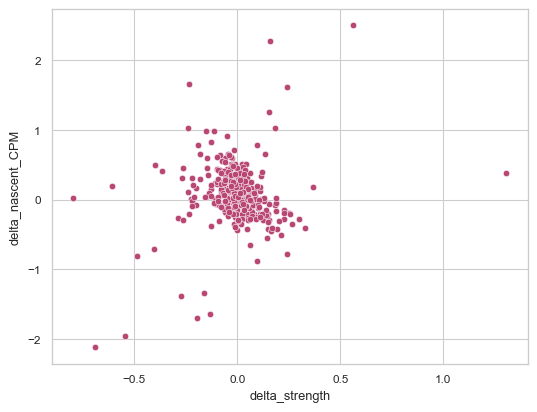

In [34]:
g = sns.scatterplot(data=operons_df_scatter_top, x='delta_strength', y='delta_nascent_CPM')
# g.set(ylim=(-10, 50)) #, xlim=(None, 2)

# GO

In [5]:
# Get http://geneontology.org/ontology/go-basic.obo
from goatools.base import download_go_basic_obo
obo_fname = download_go_basic_obo()

$ get http://purl.obolibrary.org/obo/go/go-basic.obo
requests.get(http://purl.obolibrary.org/obo/go/go-basic.obo, stream=True)
  WROTE: go-basic.obo



In [6]:
# Get ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/gene2go.gz
from goatools.base import download_ncbi_associations
file_gene2go = download_ncbi_associations()

$ get ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/gene2go.gz
FTP RETR ftp.ncbi.nlm.nih.gov gene/DATA gene2go.gz -> gene2go.gz
$ gunzip gene2go.gz


In [7]:
from goatools.obo_parser import GODag

obodag = GODag("go-basic.obo")

go-basic.obo: fmt(1.2) rel(2024-06-17) 45,494 Terms


In [8]:
from __future__ import print_function
from goatools.anno.genetogo_reader import Gene2GoReader

# Read NCBI's gene2go. Store annotations in a list of namedtuples
objanno = Gene2GoReader(file_gene2go, taxids=[511145])

# Get associations for each branch of the GO DAG (BP, MF, CC)
ns2assoc = objanno.get_ns2assc()

for nspc, id2gos in ns2assoc.items():
    print("{NS} {N:,} annotated E. coli genes".format(NS=nspc, N=len(id2gos)))


HMS:0:01:04.851564  41,047 annotations,  3,842 genes,  4,140 GOs, 1 taxids READ: gene2go 
CC 2,995 annotated E. coli genes
BP 3,276 annotated E. coli genes
MF 3,235 annotated E. coli genes


In [9]:
from goatools.cli.ncbi_gene_results_to_python import ncbi_tsv_to_py

ncbi_tsv = 'data/gene_result.txt'
output_py = 'scripts/genes_ncbi_511145_proteincoding.py'
ncbi_tsv_to_py(ncbi_tsv, output_py)

       4,640 lines READ:  data/gene_result.txt
       4,640 geneids WROTE: scripts/genes_ncbi_511145_proteincoding.py


In [21]:
import sys
sys.path.append('/home/izhegalova/ecoli_microc/scripts')
from genes_ncbi_511145_proteincoding import GENEID2NT as GeneID2nt_ecoli

In [12]:
# Get the data for one gene
nt_gene = next(iter(sorted(GENEID2NT.values())))

# Print the field name and value for all fields for one gene
for key, val in sorted(nt_gene._asdict().items()):
    print('{:15} {}'.format(key, val))

Aliases         ['b4308', 'ECK4299']
CurrentID       0
GeneID          944740
OMIM            []
Org_name        Escherichia coli str. K-12 substr. MG1655
Status          live
Symbol          yjhR
chromosome      
description     pseudo
end_position_on_the_genomic_accession 4536031
exon_count      0
genomic_nucleotide_accession_version NC_000913.3
map_location    
no_hdr0         
orientation     plus
other_designations 
start_position_on_the_genomic_accession 4535015
tax_id          511145


In [16]:
nts = [nt for nt in GENEID2NT.values() if nt.start_position_on_the_genomic_accession != '']
nts = sorted(nts, key=lambda nt: nt.GeneID)
print('{N:,} genes have specific genomic basepair locations'.format(N=len(nts)))

4,639 genes have specific genomic basepair locations


In [17]:
print('GeneID Symbol   Description')
print('------ -------  --------------------------------------------------------')
for nt_gene in nts[:20]:
    print('{GeneID:6} {Symbol:8} {description}'.format(**nt_gene._asdict()))

GeneID Symbol   Description
------ -------  --------------------------------------------------------
944740 yjhR     pseudo
944741 nfrA     exopolysaccharide secretion system outer membrane protein NfrA
944742 thrL     thr operon leader peptide
944743 insB1    IS1 family protein InsB
944744 sspA     stringent starvation protein A
944745 yaaJ     putative transporter YaaJ
944747 yaaX     DUF2502 domain-containing protein YaaX
944748 talB     transaldolase B
944749 yaaA     DNA binding and peroxide stress response protein YaaA
944750 dnaK     chaperone protein DnaK
944751 yaaI     DUF2541 domain-containing protein YaaI
944752 yfaX     putative DNA-binding transcriptional regulator YfaX
944753 dnaJ     chaperone protein DnaJ
944754 insL1    IS186/IS421 family transposase
944756 mokC     regulatory protein MokC
944757 nhaR     DNA-binding transcriptional activator NhaR
944758 nhaA     Na(+):H(+) antiporter NhaA
944759 rpsT     30S ribosomal subunit protein S20
944760 mog      molybdopterin

In [19]:
sym2nt = {nt.Symbol:nt for nt in nts}
print('{N:,} gene symbols'.format(N=len(sym2nt)))
# assert len(nts) == len(sym2nt)

4,638 gene symbols


In [20]:
# Choose a specific gene
symbol = 'yjhR'

# Print NCBI information for the chosen gene
for field, value in sorted(sym2nt[symbol]._asdict().items()):
    print('{FLD:15} {VAL:}'.format(FLD=field, VAL=value))

Aliases         ['b4308', 'ECK4299']
CurrentID       0
GeneID          944740
OMIM            []
Org_name        Escherichia coli str. K-12 substr. MG1655
Status          live
Symbol          yjhR
chromosome      
description     pseudo
end_position_on_the_genomic_accession 4536031
exon_count      0
genomic_nucleotide_accession_version NC_000913.3
map_location    
no_hdr0         
orientation     plus
other_designations 
start_position_on_the_genomic_accession 4535015
tax_id          511145


In [102]:
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS

goeaobj = GOEnrichmentStudyNS(
        GeneID2nt_ecoli, # List of E. coli protein-coding genes
        ns2assoc, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = True,
        alpha = 0.05, # default significance cut-off
        methods = ['fdr_bh']) # defult multipletest correction method


Load BP Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 71%  3,276 of  4,640 population items found in association

Load CC Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 65%  2,995 of  4,640 population items found in association

Load MF Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 70%  3,235 of  4,640 population items found in association


## create study DF

In [45]:
Hp_middle = bf.read_table('data/hairpins_25.middle.bed', schema='bed3')
Hp_middle.head()

,chrom,start,end
0,NC_000913.3,58825,58850
1,NC_000913.3,84650,84675
2,NC_000913.3,151325,151350
3,NC_000913.3,151800,151825
4,NC_000913.3,152325,152350


In [28]:
annotation_gff = bf.read_table('data/NC_000913.gff', schema='gff')
genes_gff = annotation_gff.query('feature=="gene"')
# genes_gff['attributes'].str.split(';', n=6, expand=True)
genes_gff[['ID', 'name', 'geneID', 'gbkey', 'gene_name', 'gene_synonym', 'tag']] = genes_gff['attributes'].str.split(';', n=6, expand=True)
genes_gff[['EcoGene', 'geneID']] = genes_gff['geneID'].str.split(',', n=1, expand=True)
genes_gff['Synonym'] = genes_gff.tag.str.replace('locus_tag=', '', regex=True).tolist()
genes_gff['Gene name'] = genes_gff.name.str.replace('Name=', '', regex=True).tolist()
genes_gff.head()

,chrom,source,feature,start,end,score,strand,frame,attributes,ID,name,geneID,gbkey,gene_name,gene_synonym,tag,EcoGene,Synonym,Gene name
1,NC_000913.3,RefSeq,gene,190,255,.,+,.,"ID=gene0;Name=thrL;Dbxref=EcoGene:EG11277,Gene...",ID=gene0,Name=thrL,GeneID:944742,gbkey=Gene,gene=thrL,"gene_synonym=ECK0001,JW4367",locus_tag=b0001,Dbxref=EcoGene:EG11277,b0001,thrL
3,NC_000913.3,RefSeq,gene,337,2799,.,+,.,"ID=gene1;Name=thrA;Dbxref=EcoGene:EG10998,Gene...",ID=gene1,Name=thrA,GeneID:945803,gbkey=Gene,gene=thrA,"gene_synonym=ECK0002,Hs,JW0001,thrA1,thrA2,thrD",locus_tag=b0002,Dbxref=EcoGene:EG10998,b0002,thrA
5,NC_000913.3,RefSeq,gene,2801,3733,.,+,.,"ID=gene2;Name=thrB;Dbxref=EcoGene:EG10999,Gene...",ID=gene2,Name=thrB,GeneID:947498,gbkey=Gene,gene=thrB,"gene_synonym=ECK0003,JW0002",locus_tag=b0003,Dbxref=EcoGene:EG10999,b0003,thrB
7,NC_000913.3,RefSeq,gene,3734,5020,.,+,.,"ID=gene3;Name=thrC;Dbxref=EcoGene:EG11000,Gene...",ID=gene3,Name=thrC,GeneID:945198,gbkey=Gene,gene=thrC,"gene_synonym=ECK0004,JW0003",locus_tag=b0004,Dbxref=EcoGene:EG11000,b0004,thrC
9,NC_000913.3,RefSeq,gene,5234,5530,.,+,.,"ID=gene4;Name=yaaX;Dbxref=EcoGene:EG14384,Gene...",ID=gene4,Name=yaaX,GeneID:944747,gbkey=Gene,gene=yaaX,"gene_synonym=ECK0005,JW0004",locus_tag=b0005,Dbxref=EcoGene:EG14384,b0005,yaaX


In [13]:
import re
genes_gff['gene_go'] = genes_gff.geneID.str.replace('GeneID:', '', regex=True).tolist()
genes_gff['gene_go'] = genes_gff['gene_go'].astype('Int64')
# [re.sub("GeneID:", "", string) for string in genes_gff.geneID.tolist()]
genes_gff.head()

,chrom,source,feature,start,end,score,strand,frame,attributes,ID,name,geneID,gbkey,gene_name,synonym,tag,EcoGene,gene_go
1,NC_000913.3,RefSeq,gene,190,255,.,+,.,"ID=gene0;Name=thrL;Dbxref=EcoGene:EG11277,Gene...",ID=gene0,Name=thrL,GeneID:944742,gbkey=Gene,gene=thrL,"gene_synonym=ECK0001,JW4367",locus_tag=b0001,Dbxref=EcoGene:EG11277,944742
3,NC_000913.3,RefSeq,gene,337,2799,.,+,.,"ID=gene1;Name=thrA;Dbxref=EcoGene:EG10998,Gene...",ID=gene1,Name=thrA,GeneID:945803,gbkey=Gene,gene=thrA,"gene_synonym=ECK0002,Hs,JW0001,thrA1,thrA2,thrD",locus_tag=b0002,Dbxref=EcoGene:EG10998,945803
5,NC_000913.3,RefSeq,gene,2801,3733,.,+,.,"ID=gene2;Name=thrB;Dbxref=EcoGene:EG10999,Gene...",ID=gene2,Name=thrB,GeneID:947498,gbkey=Gene,gene=thrB,"gene_synonym=ECK0003,JW0002",locus_tag=b0003,Dbxref=EcoGene:EG10999,947498
7,NC_000913.3,RefSeq,gene,3734,5020,.,+,.,"ID=gene3;Name=thrC;Dbxref=EcoGene:EG11000,Gene...",ID=gene3,Name=thrC,GeneID:945198,gbkey=Gene,gene=thrC,"gene_synonym=ECK0004,JW0003",locus_tag=b0004,Dbxref=EcoGene:EG11000,945198
9,NC_000913.3,RefSeq,gene,5234,5530,.,+,.,"ID=gene4;Name=yaaX;Dbxref=EcoGene:EG14384,Gene...",ID=gene4,Name=yaaX,GeneID:944747,gbkey=Gene,gene=yaaX,"gene_synonym=ECK0005,JW0004",locus_tag=b0005,Dbxref=EcoGene:EG14384,944747


In [96]:
genes_at_Hpcenter = bf.overlap(genes_gff, Hp_middle, how='inner')
genes_at_Hpcenter.head()

,chrom,source,feature,start,end,score,strand,frame,attributes,ID,gene_name,geneID,EcoGene,gene_go,chrom_,start_,end_
0,NC_000913.3,RefSeq,gene,58474,59269,.,+,.,"gbkey=Gene;gene=yabP;gene_synonym=ECK0057,JW00...",ID=gene55,Name=yabP,GeneID:944776,Dbxref=EcoGene:EG12610,944776,NC_000913.3,58825,58850
1,NC_000913.3,RefSeq,gene,84368,85312,.,+,.,"gbkey=Gene;gene=leuO;gene_synonym=ECK0078,JW00...",ID=gene76,Name=leuO,GeneID:949034,Dbxref=EcoGene:EG10531,949034,NC_000913.3,84650,84675
2,NC_000913.3,RefSeq,gene,151003,151599,.,-,.,"gbkey=Gene;gene=yadK;gene_synonym=ECK0135,JW01...",ID=gene133,Name=yadK,GeneID:944835,Dbxref=EcoGene:EG12325,944835,NC_000913.3,151325,151350
3,NC_000913.3,RefSeq,gene,151626,152231,.,-,.,"gbkey=Gene;gene=yadL;gene_synonym=ECK0136,JW01...",ID=gene134,Name=yadL,GeneID:944829,Dbxref=EcoGene:EG12326,944829,NC_000913.3,151800,151825
4,NC_000913.3,RefSeq,gene,152243,152812,.,-,.,"gbkey=Gene;gene=yadM;gene_synonym=ECK0137,JW01...",ID=gene135,Name=yadM,GeneID:944828,Dbxref=EcoGene:EG12327,944828,NC_000913.3,152325,152350


## run GO

In [97]:
geneids_study = genes_at_Hpcenter.gene_go.tolist()

In [103]:
goea_results_all = goeaobj.run_study(geneids_study)
goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]


Runing BP Ontology Analysis: current study set of 221 IDs.
 70%    143 of    205 study items found in association
 93%    205 of    221 study items found in population(4640)
Calculating 2,898 uncorrected p-values using fisher_scipy_stats
   2,898 terms are associated with  3,276 of  4,640 population items
     547 terms are associated with    143 of    210 study items
  METHOD fdr_bh:
      26 GO terms found significant (< 0.05=alpha) ( 19 enriched +   7 purified): statsmodels fdr_bh
      44 study items associated with significant GO IDs (enriched)
      61 study items associated with significant GO IDs (purified)

Runing CC Ontology Analysis: current study set of 221 IDs.
 57%    117 of    205 study items found in association
 93%    205 of    221 study items found in population(4640)
Calculating 312 uncorrected p-values using fisher_scipy_stats
     312 terms are associated with  2,995 of  4,640 population items
      42 terms are associated with    117 of    210 study items
  METH

In [101]:
# goeaobj.wr_xlsx("results/nbt3102_symbols.xlsx", goea_results_sig, itemid2name=geneid2symbol)
goeaobj.wr_xlsx("results/nbt3102_geneids.propogate.xlsx", goea_results_sig)

      9 items WROTE: results/nbt3102_geneids.xlsx


# HGT

In [45]:
hgt_df = pd.read_csv('data/HGT-db.ecoli.csv')
hgt_df['Gene name'] = hgt_df['Gene name'].str.replace(' ', '', regex=True).tolist()
hgt_df['Synonym'] = hgt_df['Synonym'].str.replace(' ', '', regex=True).tolist()
hgt_df.head()

,Coordinates,Strand,Length,PID,Gene name,Synonym,FunctionCode,COG,GCRegion,HGT,SimGC,SimMah,Dev.AA,Function
0,34195..34695,+,498,16128028,caiF,b0034,-,-,NaN,H,1,1,NaN,transcriptional regulator of cai operon
1,149715..150953,-,1236,16128128,yadC,b0135,-,-,-,H,2,0,+T 3.7,putative fimbrial-like protein
2,151003..151599,-,594,16128129,yadK,b0136,-,-,-,H,2,0,+S 3.4,putative fimbrial protein
3,151626..152231,-,603,16128130,yadL,b0137,-,-,-,H,1,2,+T 4.5,putative fimbrial protein
4,152243..152854,-,609,16128131,yadM,b0138,N,COG3539,-,H,1,1,+T 4.1,putative fimbrial-like protein


In [72]:
HGT_genes_df = pd.merge(genes_gff, hgt_df, on='Synonym', how='inner')
HGT_genes_df.loc[:, ['chrom', 'start', 'end', 'Synonym', 'score', 'strand']].to_csv('data/HGT_genes.bed', 
                                                                                     index=False, header=False, 
                                                                                      sep='\t')
# HGT_genes_df.query('feature != "gene"')[['Synonym', 'Gene name_y']].head()

In [68]:
Hp_df = bf.read_table('data/hairpins_25.bed', schema='bed')
Hp_df.head()

,chrom,start,end,name,score,strand
0,NC_000913.3,58250,59425,NaN,NaN,NaN
1,NC_000913.3,83450,85875,NaN,NaN,NaN
2,NC_000913.3,150050,152625,NaN,NaN,NaN
3,NC_000913.3,150050,153550,NaN,NaN,NaN
4,NC_000913.3,150050,154625,NaN,NaN,NaN


In [66]:
bf.overlap(Hp_df, HGT_genes_df, how='inner').shape

(336, 35)

In [9]:
!wc -l data/HGT_genes.bed

299 data/HGT_genes.bed


161


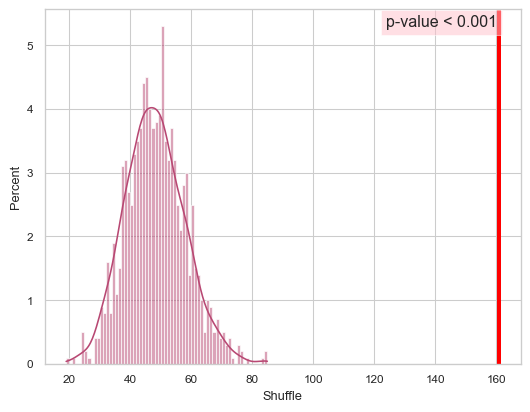

In [34]:
import sys
sys.path.append('/home/izhegalova/ecoli_microc/scripts/')
from functions import pValue_featureOccurenceInLoop
# for F in [0.01, 0.1, 0.25, 0.5]:
pValue_featureOccurenceInLoop(
        file_loops="data/hairpins_25.bed",
        time=None,
        mode='whole',
        N_shuffle=1_000,
        file_features='data/HGT_genes.bed', 
        name="HGT_Hps", 
        genome_file="data/genome.chrom.sizes",
        pic_path="results",
        resolution=25, fraction=0.1, Fraction=0.01, return_df=False)

111


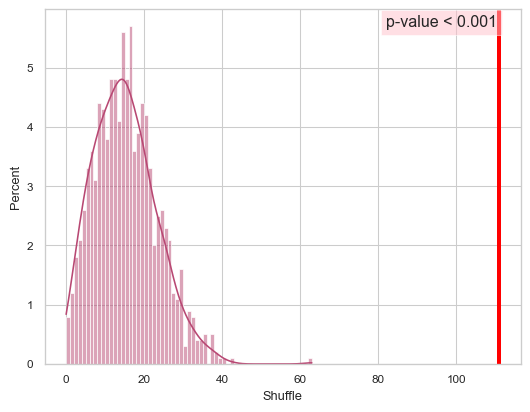

In [32]:
import sys
sys.path.append('/home/izhegalova/ecoli_microc/scripts/')
from functions import pValue_featureOccurenceInLoop
# for F in [0.01, 0.1, 0.25, 0.5]:
pValue_featureOccurenceInLoop(
        file_loops="data/hTADS_25.bed",
        time=None,
        mode='whole',
        N_shuffle=1_000,
        file_features='data/HGT_genes.bed', 
        name="HGT_hCD", 
        genome_file="data/genome.chrom.sizes",
        pic_path="results",
        resolution=25, fraction=0.1, Fraction=0.01, return_df=False)

/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/bioframe/io/fileops.py:74: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(filepath_or, **kwargs)


66


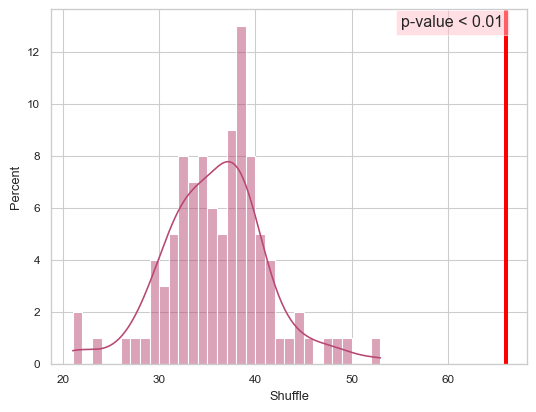

In [18]:
import sys
sys.path.append('/home/izhegalova/ecoli_microc/scripts/')
from functions import pValue_featureOccurenceInLoop
pValue_featureOccurenceInLoop(
        file_loops="data/HGT_genes.bed",
        time=None,
        mode='whole',
        N_shuffle=100,
        file_features='data/h-ns/NegRif_HNS_merged_peaks.bed', 
        name="H-NS_HGT", 
        genome_file="data/genome.chrom.sizes",
        pic_path="results",
        resolution=25, fraction=0.1, return_df=False)